In [1]:
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Setting seeds for reproducibility


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**


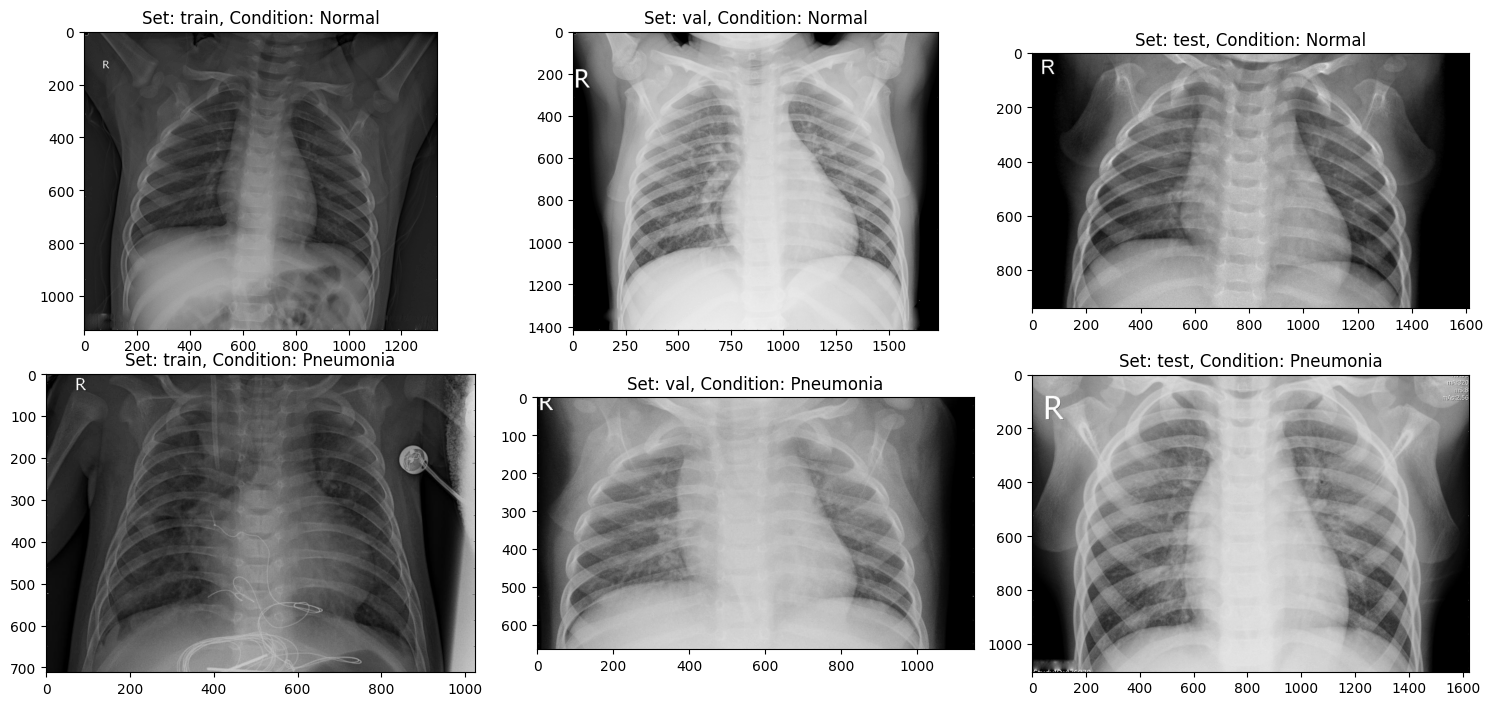

In [2]:
# input_path = '../input/chest_xray/chest_xray/'
input_path = '../input/chest-xray-pneumonia//chest_xray/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [3]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


In [4]:
# input_path = '../input/chest_xray/chest_xray/'
input_path = '../input/chest-xray-pneumonia//chest_xray/chest_xray/'

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen=ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    val_gen = val_datagen.flow_from_directory(
    directory=input_path+'val', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels,val_gen

In [5]:
# Hyperparameters
img_dims = 150
epochs = 10
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels ,val_gen= process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [6]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# # Fourth conv block
# x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2))(x)
# x = Dropout(rate=0.2)(x)

# # Fifth conv block
# x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2))(x)
# x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [7]:
# Fitting the model
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=val_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[ lr_reduce])

Epoch 1/10
163/163 [==============================] - 116s 636ms/step - loss: 0.3802 - accuracy: 0.8236 - val_loss: 2.3774 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 71s 437ms/step - loss: 0.2617 - accuracy: 0.8896 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 73s 447ms/step - loss: 0.2346 - accuracy: 0.9036 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 71s 435ms/step - loss: 0.2172 - accuracy: 0.9099 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 71s 436ms/step - loss: 0.1933 - accuracy: 0.9262 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 71s 435ms/step - loss: 0.1871 - accuracy: 0.9281 - lr: 0.0010
Epoch 7/10
163/163 [==============================] - 71s 437ms/step - loss: 0.1808 - accuracy: 0.9331 - lr: 0.0010
Epoch 8/10
163/163 [==============================] - 70s 430ms/step - loss: 0.1693 - accuracy: 0.9356 - lr: 0.0010
Epoch 9/10
163/163 [=========

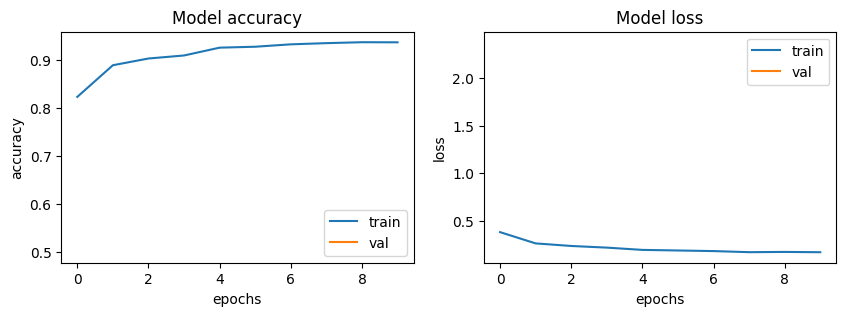

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i , met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

20/20 [==============================] - 0s 9ms/step
CONFUSION MATRIX ------------------
[[212  22]
 [ 67 323]]

TEST METRICS ----------------------
Accuracy: 85.73717948717949%
Precision: 93.6231884057971%
Recall: 82.82051282051283%
F1-score: 87.89115646258503

TRAIN METRIC ----------------------
Train acc: 93.73


In [10]:
import cv2
import numpy as np

input_image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_486.jpeg"
input_image = cv2.imread(input_image_path)

input_image_resize = cv2.resize(input_image, (150, 150))
input_image_scaled = input_image_resize / 255.0
image_reshaped = np.reshape(input_image_scaled, [1, 150, 150, 3])
input_prediction = model.predict(image_reshaped)
# input_pred_label = np.argmax(input_prediction)
if input_prediction <0.5:
   print('The image represents a normal')
else:
   print('The image represents a PNEUMONIA')



1/1 [==============================] - 0s 57ms/step
The image represents a PNEUMONIA


In [11]:
input_prediction

array([[0.94743335]], dtype=float32)

In [15]:
model.save('penomena.h5')

In [20]:
model.save("model.keras")

In [24]:
model = tf.keras.models.load_model('model.keras')


In [12]:
for cond in [ '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
          
            image_reshaped = np.reshape(img, [1, 150, 150, 3])
# input_pred_label = np.argmax(input_prediction)
            input_prediction = model.predict(image_reshaped)  
            if input_prediction <0.5:
              print('The image represents a normal')
#               print('The image url '+input_path+'test'+cond+img)

              
            else:
              print('The image represents a PNEUMONIA')

1/1 [==============================] - 0s 22ms/step
The image represents a PNEUMONIA
1/1 [==============================] - 0s 19ms/step
The image represents a PNEUMONIA
1/1 [==============================] - 0s 20ms/step
The image represents a normal
1/1 [==============================] - 0s 21ms/step
The image represents a PNEUMONIA
1/1 [==============================] - 0s 19ms/step
The image represents a PNEUMONIA
1/1 [==============================] - 0s 20ms/step
The image represents a normal
1/1 [==============================] - 0s 20ms/step
The image represents a PNEUMONIA
1/1 [==============================] - 0s 20ms/step
The image represents a PNEUMONIA
1/1 [==============================] - 0s 22ms/step
The image represents a PNEUMONIA
1/1 [==============================] - 0s 20ms/step
The image represents a PNEUMONIA
1/1 [==============================] - 0s 21ms/step
The image represents a normal
1/1 [==============================] - 0s 21ms/step
The image represents a

NameError: name 'predictions' is not defined